# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry with Constant Kzz (~Elf Owl)

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done for the Elf-OWL Grid [Mukherjee et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240200756M/abstract) (note this should also be cited along with [PICASO 4.0]() if using this code/tutorial).

What you should already be familiar with:

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/notebooks/A_basics/5_AddingThermalFlux.html)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/D_climate/1_BrownDwarf_PreW.html)

What you should have downloaded:

1. [Download](https://doi.org/10.5281/zenodo.18644980) New 1460, 661 wno Correlated-k Tables to be used by the climate code for opacity by individual molecule

Use the `data.get_data` helper function to get resortrebin files and add them to the default picaso location: `reference/opaities/resortrebin`
 >> import picaso.data as d

 >>d.get_data(category_download='ck_tables',target_download='by-molecule')

### First, check that you have downloaded and placed the correlated-k files in the correct folder

In [1]:
import os;import glob
os.listdir(os.path.join(os.getenv('picaso_refdata'),'opacities','resortrebin')) #should show you a list of files

['readme',
 'O2_1460.hdf5',
 'PH3_1460.hdf5',
 'Rb_1460.hdf5',
 'TiH_1460.hdf5',
 'TiO_1460.hdf5',
 'npy',
 'AlH_1460.hdf5',
 'C2H2_1460.hdf5',
 'C2H4_1460.hdf5',
 'C2H6_1460.hdf5',
 'CaH_1460.hdf5',
 'CH4_1460.hdf5',
 'CO_1460.hdf5',
 'CO2_1460.hdf5',
 'CrH_1460.hdf5',
 'Cs_1460.hdf5',
 'Fe_1460.hdf5',
 'FeH_1460.hdf5',
 'H2_1460.hdf5',
 'H2O_1460.hdf5',
 'H2S_1460.hdf5',
 'H3+_1460.hdf5',
 'HCN_1460.hdf5',
 'K_1460.hdf5',
 'Li_1460.hdf5',
 'LiCl_1460.hdf5',
 'LiF_1460.hdf5',
 'LiH_1460.hdf5',
 'MgH_1460.hdf5',
 'N2_1460.hdf5',
 'Na_1460.hdf5',
 'NH3_1460.hdf5',
 'O3_1460.hdf5',
 'OCS_1460.hdf5',
 'SiO_1460.hdf5',
 'SO2_1460.hdf5',
 'VO_1460.hdf5',
 '196']

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy import constants as const
from astropy import units as u
import sys
import pandas as pd

## Setting up Initial Run (highlighting main differences for disequilibrium)

In [3]:
gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','He','PH3','C2H2','Na','K','TiO','VO','FeH']

opacity_ck = jdi.opannection(method='resortrebin',preload_gases=gases_fly) # grab your opacities

In [4]:
elf = jdi.xr.load_dataset('spectra_logzz_9.0_teff_950.0_grav_56.0_mh_0.7_co_1.0.nc')
elf

<xarray.Dataset> Size: 3MB
Dimensions:      (wavelength: 193132, pressure: 91)
Coordinates:
  * wavelength   (wavelength) float64 2MB 15.0 15.0 15.0 15.0 ... 0.6 0.6 0.6
  * pressure     (pressure) float64 728B 0.0001778 0.000205 ... 55.23 63.66
Data variables: (12/40)
    flux         (wavelength) float64 2MB 1.716e+09 1.722e+09 ... 3.777e+05
    temperature  (pressure) float64 728B 309.6 310.7 ... 3.227e+03 3.306e+03
    e-           (pressure) float64 728B 4.5e-38 4.5e-38 ... 9.713e-07 1.125e-06
    H2           (pressure) float64 728B 0.8272 0.8272 0.8271 ... 0.7973 0.7927
    H            (pressure) float64 728B 4.298e-33 5.412e-33 ... 0.03637 0.04143
    H+           (pressure) float64 728B 4.5e-38 4.5e-38 ... 7.752e-17 2.247e-16
    ...           ...
    OCS          (pressure) float64 728B 1.032e-25 1.018e-25 ... 8.842e-09
    Li           (pressure) float64 728B 4.5e-38 4.5e-38 ... 1.394e-08 1.379e-08
    LiOH         (pressure) float64 728B 4.5e-38 4.5e-38 ... 6.835e-10 6.427e-10
    LiH          (pressure) float64 728B 4.5e-38 4.5e-38 ... 2.646e-09 2.753e-09
    LiCl         (pressure) float64 728B 4.5e-38 4.5e-38 ... 9.78e-12 8.207e-12
    LiF          (pressure) float64 728B 4.5e-38 4.5e-38 ... 4.567e-13 3.971e-13
Attributes:
    author:         Batalha,Mukherjee
    contact:        natasha.e.batalha@nasa.gov
    code:           {"spectra": "PICASO", "chemistry": "visccher"}
    doi:            ELF OWL Paper
    planet_params:  {"logg": {"value": 56.0, "unit": "m / s2"}, "teff": {"val...

In [5]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

tint= 950
grav = 56 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

nlevel = 91

In this case, let's start with an Elf Owl profile since that's the model we want to reproduce here

In [6]:
pressure,temp_guess = elf.coords['pressure'].values, elf.data_vars['temperature'].values

rcb_guess = 70 # top most level of guessed convective zone

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

**New code parameter**:
1. `quench`: This makes sure the do quench chemistry for disequilibrium runs. Default = False. This parameter should be included in the atmosphere function


In [7]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                        rcb_guess=rcb_guess, rfacv = rfacv)

mh=10**eval(elf.attrs['planet_params'])['mh']#NOT LOG
cto_relative = eval(elf.attrs['planet_params'])['cto'] #relative to solar

#now that we are not using preweighted ck tables we need to tell picaso how to compute chemistry on the fly
cl_run.atmosphere(mh=mh, cto_relative=cto_relative, chem_method='visscher', quench=True)

### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$:

 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...942...71M/abstract))


**New code parameters**:

1. `diseq_chem=True` : Turns on disequilibrium chemistry
2. `self_consistent_kzz` : (True/False) This solves self consistently for
3. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
4. `kz` : constant value if `self_consistent_kzz=False`

**Which of those 4 do I need change change**

Likely you will only be changing `kz` and/or, for example, playing around with a `self_consistent_kzz` vs a `constant profile`. Unless you are certain, we recommend the following set of `gases_fly` to remain unchanged.


In [8]:
#following elf-owl lets use a constant value for all pressures
kzval = pressure*0+10**eval(elf.attrs['planet_params'])['logkzz']

In [9]:
cl_run.inputs['atmosphere']['profile']['kz']=kzval#cm2/s

out = cl_run.climate(opacity_ck, save_all_profiles = True, with_spec=True,
        save_all_kzz = False, self_consistent_kzz=False,diseq_chem = True)

SUMMARY
-------
Clouds: False
quench True
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Kzz for chem: [1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09 1.e+09
 1.e+09]


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  311.7888929819371 3339.924348469608 , flux balance  0.024581614358263067
Iteration number  1 , min , max temp  317.19104010248685 3414.765288235701 , flux balance  0.0064723295145607315


Iteration number  2 , min , max temp  317.1554340054866 3409.3164207425584 , flux balance  6.445705680005772e-05
In t_start: Converged Solution in iterations  2
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  317.1554340054866 0
Iteration number  0 , min , max temp  315.31219610597043 3443.4500157258617 , flux balance  0.01502619330672437


Iteration number  1 , min , max temp  314.2456759764268 3458.851564624847 , flux balance  0.0003755462598890101
Iteration number  2 , min , max temp  314.2210464173156 3458.646074543088 , flux balance  2.184600048546174e-06
In t_start: Converged Solution in iterations  2
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(69), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  314.2210464173156 1
Iteration number  0 , min , max temp  311.9263904584065 3483.1922595262245 , flux balance  0.0006326468705814281
Iteration number  1 , min , max temp  311.852055457624 3482.6372252102087 , flux balance  3.5705730806533994e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(69), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  311.852055457624 2
Iteration number  0 , min , max temp  311.65648340492726 3494.4743300179425 , flux balance  0.00014109688798530828


Iteration number  1 , min , max temp  311.6512259229473 3494.3641556149655 , flux balance  7.067906279892352e-07
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(69), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Move up two levels


Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  313.1559990213211 3371.4613706601885 , flux balance  0.000107272983346283
Iteration number  1 , min , max temp  313.16965845246784 3371.2661459426463 , flux balance  1.2483426087631298e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  313.16965845246784 0
Iteration number  0 , min , max temp  310.554210043683 3376.3654291126863 , flux balance  1.2906990115343876e-05
 We are already at a root, tolf , test =  5e-05 ,  4.115969068308286e-05
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  316.4999229814992 3353.0029237328677 , flux balance  0.00010837813681962465
Iteration number  1 , min , max temp  316.40878246538415 3352.898625217187 , flux balance  1.2897101754902632e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(67), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  316.40878246538415 0
Iteration number  0 , min , max temp  315.307742160827 3356.329399956271 , flux balance  -2.2997130383507603e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(67), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  320.4434357995544 3340.8991610989815 , flux balance  0.00015935359814091946
Iteration number  1 , min , max temp  320.39118416803154 3340.7742938435463 , flux balance  2.5010628522865695e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  320.39118416803154 0
Iteration number  0 , min , max temp  318.95721843945495 3343.944567049469 , flux balance  -3.4627907689209256e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  324.3187597285869 3332.7047361092136 , flux balance  0.00021100777636911183
Iteration number  1 , min , max temp  324.2628396434233 3332.566680038169 , flux balance  3.926445959505669e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  324.2628396434233 0
Iteration number  0 , min , max temp  322.58475192300676 3335.839987729117 , flux balance  -5.539262537671197e-05
Iteration number  1 , min , max temp  322.54489747228195 3335.866641980761 , flux balance  -7.72486965780538e-07
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(60), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  326.8574685223621 3326.1507169265687 , flux balance  8.884203543140832e-05
Iteration number  1 , min , max temp  326.8452400728235 3326.051904337655 , flux balance  3.3028835669233685e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  326.8452400728235 0
Iteration number  0 , min , max temp  324.2946503090344 3328.793550097379 , flux balance  -6.482959177693949e-05
Iteration number  1 , min , max temp  324.22072317731653 3328.825195714874 , flux balance  -1.1693906597357378e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  322.24367984965426 3318.725945547681 , flux balance  -0.0001268247826505738
Iteration number  1 , min , max temp  322.213643363538 3318.7006648080173 , flux balance  2.629284320390065e-07
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  322.213643363538 0
Iteration number  0 , min , max temp  325.7245568634752 3322.0967964344472 , flux balance  -0.00013383631374573216
Iteration number  1 , min , max temp  325.7213335261152 3322.144058982757 , flux balance  -2.4597214058851905e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  324.30495500007277 3312.2123192143013 , flux balance  -0.00025451321072521266
Iteration number  1 , min , max temp  324.30273481540013 3312.2391913472225 , flux balance  -2.682611370094255e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  324.30273481540013 0
Iteration number  0 , min , max temp  328.3433008938265 3317.11032348552 , flux balance  -0.00020817118429869447
Iteration number  1 , min , max temp  328.33289583737064 3317.1834102821012 , flux balance  -4.5703539900279035e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  326.6199067374844 3307.752253295394 , flux balance  -0.0004193164445538154
Iteration number  1 , min , max temp  326.61586203102223 3307.8465702692356 , flux balance  -7.893179107303743e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  326.61586203102223 0
Iteration number  0 , min , max temp  324.1917920514233 3311.0959071138236 , flux balance  -0.00017817233366618026
Iteration number  1 , min , max temp  324.12987721571676 3311.161615219682 , flux balance  -4.713047817138429e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(68), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  328.17206351402564 3302.801778575398 , flux balance  -0.0004919186124056691
Iteration number  1 , min , max temp  328.20219557124636 3302.914659169533 , flux balance  -1.084481292634217e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  328.20219557124636 0
Iteration number  0 , min , max temp  326.5361235223817 3306.7951044167366 , flux balance  -0.0002706896910578303


Iteration number  1 , min , max temp  326.50858823802497 3306.8848040387334 , flux balance  -7.768443875041848e-06
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  330.1915731551984 3299.7402350073285 , flux balance  -0.0006485520227750371
Iteration number  1 , min , max temp  330.23992633121725 3299.906235866049 , flux balance  -1.753466854731298e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Big iteration is  330.23992633121725 0
Iteration number  0 , min , max temp  328.64510653330626 3303.6946411484673 , flux balance  -0.0003091062547174923
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(70), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  331.9343914643784 3297.247691431184 , flux balance  -0.0008275393619851546
Iteration number  1 , min , max temp  332.00097221441956 3297.4728588183652 , flux balance  -2.603805833133398e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  332.00097221441956 0
Iteration number  0 , min , max temp  329.9321522380218 3300.570406503708 , flux balance  -0.0002925807739775384


Iteration number  1 , min , max temp  329.89157234679624 3300.6662799855453 , flux balance  -1.0641847449153232e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  333.4876555653655 3295.142601415301 , flux balance  -0.0009829868136370303
Iteration number  1 , min , max temp  333.5601667527869 3295.414894296259 , flux balance  -3.455644210728815e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  333.5601667527869 0
Iteration number  0 , min , max temp  331.5653630592743 3298.4449460262867 , flux balance  -0.0003209667028747991


Iteration number  1 , min , max temp  331.5294278813195 3298.5480970431154 , flux balance  -1.2506829763959482e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(64)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  334.96866742447037 3293.4275455624443 , flux balance  -0.0011634126094739975
Iteration number  1 , min , max temp  335.0559263083083 3293.756100821299 , flux balance  -4.535643442148033e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  335.0559263083083 0
Iteration number  0 , min , max temp  333.08689665297356 3296.6769634541993 , flux balance  -0.0003468662410343225


Iteration number  1 , min , max temp  333.0534980851388 3296.7868456065216 , flux balance  -1.4702276179745163e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  336.31740665528673 3291.9513946502207 , flux balance  -0.0013612211148513202
Iteration number  1 , min , max temp  336.4185574630224 3292.3471949725476 , flux balance  -5.815468150071135e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  336.4185574630224 0
Iteration number  0 , min , max temp  334.4926913612233 3295.208290603085 , flux balance  -0.0003742826674366006


Iteration number  1 , min , max temp  334.4623999937042 3295.325446380945 , flux balance  -1.7224492210655206e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  337.5413145829779 3290.7341878211055 , flux balance  -0.0015170120702032058
Iteration number  1 , min , max temp  337.6536934553082 3291.1785992389187 , flux balance  -6.978896041850468e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  337.6536934553082 0
Iteration number  0 , min , max temp  335.78226025373874 3293.9800064354663 , flux balance  -0.00039230504590548885


Iteration number  1 , min , max temp  335.75503215377665 3294.101531523687 , flux balance  -1.9179235760612293e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(69), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  338.6661276489147 3289.732505982988 , flux balance  -0.0016760629251536233
Iteration number  1 , min , max temp  338.7880045320978 3290.2274891883026 , flux balance  -8.220472870179902e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  338.7880045320978 0
Iteration number  0 , min , max temp  336.9671590983246 3292.9375066376183 , flux balance  -0.0004071813664790517
Iteration number  1 , min , max temp  336.9424943823183 3293.064748672922 , flux balance  -2.1067777359952637e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(69), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  339.64199085474473 3288.9448684716654 , flux balance  -0.0018215847627092985
Iteration number  1 , min , max temp  339.77085007989695 3289.4853900199946 , flux balance  -9.569314858822573e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  339.77085007989695 0
Iteration number  0 , min , max temp  338.0412116544922 3292.081524952097 , flux balance  -0.00042029585271623427
Iteration number  1 , min , max temp  338.02025269438485 3292.211868675319 , flux balance  -2.292061072945853e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  340.374579427303 3288.4665848327786 , flux balance  -0.0018553777452622673
Iteration number  1 , min , max temp  340.5030338248879 3289.0192901823716 , flux balance  -0.00010236658279414693
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  340.5030338248879 0
Iteration number  0 , min , max temp  338.9393352109197 3291.4335278264507 , flux balance  -0.0004133628089366754
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  340.86529775274846 3288.283685812108 , flux balance  -0.0018050696766934477
Iteration number  1 , min , max temp  340.98599748510856 3288.8231788090284 , flux balance  -0.00010447402477122023
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  340.98599748510856 0
Iteration number  0 , min , max temp  339.620562097592 3291.0111774534603 , flux balance  -0.000396321449931573
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  341.0188196458635 3288.497672622039 , flux balance  -0.001542584405353357
Iteration number  1 , min , max temp  341.11863328421504 3288.959384790618 , flux balance  -9.349310979784567e-05
In t_start: Converged Solution in iterations  1
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  341.11863328421504 0
Iteration number  0 , min , max temp  340.04748205628954 3290.79349654454 , flux balance  -0.00035227631844297
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  340.71300028287106 3289.387358020674 , flux balance  -0.0010365607898504474
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  340.71300028287106 0
Iteration number  0 , min , max temp  340.15003168155874 3290.774719111288 , flux balance  -0.00027918638208139377
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  340.00264118604116 3290.880407394941 , flux balance  -0.00019970525344663401
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  340.00264118604116 0
Iteration number  0 , min , max temp  339.8660036520904 3291.12071898122 , flux balance  -5.1461686147197484e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
final [0, 47, 89, 0, 0, 0]


Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Iteration number  0 , min , max temp  339.8140850690643 3291.1815037406845 , flux balance  -1.3040994614532831e-05
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Big iteration is  339.8140850690643 0
Iteration number  0 , min , max temp  339.79874162439637 3291.1974661243094 , flux balance  -3.4276185013034988e-06
In t_start: Converged Solution in iterations  0
Computed quenched levels at {'CO-CH4-H2O': np.int64(69), 'CO2': np.int64(59), 'NH3-N2': np.int64(71), 'HCN': np.int64(68), 'PH3': np.int64(65)}
Quench=True; Adjusting quench chemistry


Profile converged before itmx
YAY ! ENDING WITH CONVERGENCE


(200, 0.0001)

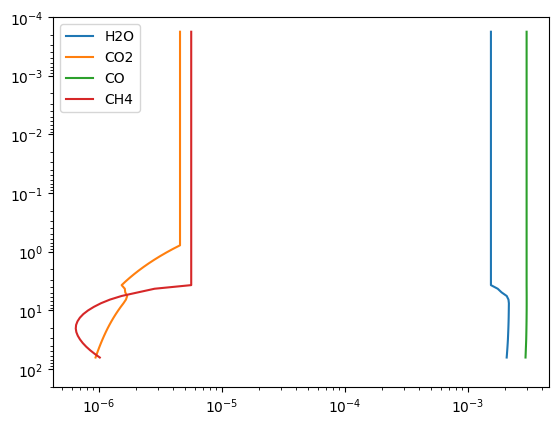

In [10]:
for i in ['H2O','CO2','CO','CH4']:
    plt.loglog(out['ptchem_df'][i], out['ptchem_df']['pressure'] ,label=i)
plt.legend()
plt.ylim([200,1e-4])

## Compare Diseq and Elf Owl Climate Profile

For the case we chose with very low kzz, and solar M/H the disequilibrium profile and bobcat profiles are identical!

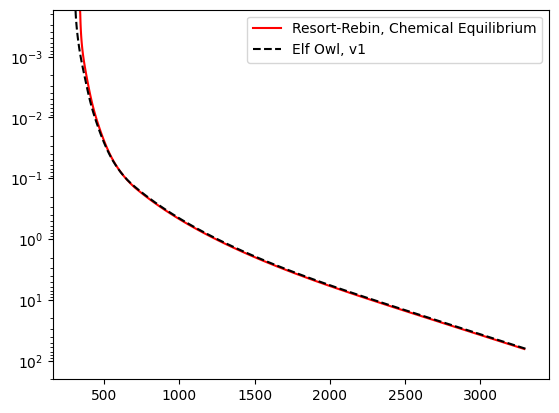

In [11]:
plt.ylim(200,1.7e-4)
plt.semilogy(out['temperature'],out['pressure'],"r", label='Resort-Rebin, Chemical Equilibrium')
plt.semilogy(temp_guess,pressure,color="k",linestyle="--", label='Elf Owl, v1')

plt.legend()